In [1]:
import pydicom as dicom
import matplotlib.pylab as plt
from skimage import measure
from plotly.tools import FigureFactory as FF
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
import os
from skimage import measure
from plotly.offline import iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *

In [2]:
root_path = 'D:/Work/Labs/NeuronNetworks/cherepushki/PA1/ST1/SE2/'

In [3]:
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [4]:
def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [5]:
id=0
patient = load_scan(root_path)
images = get_pixels_hu(patient)

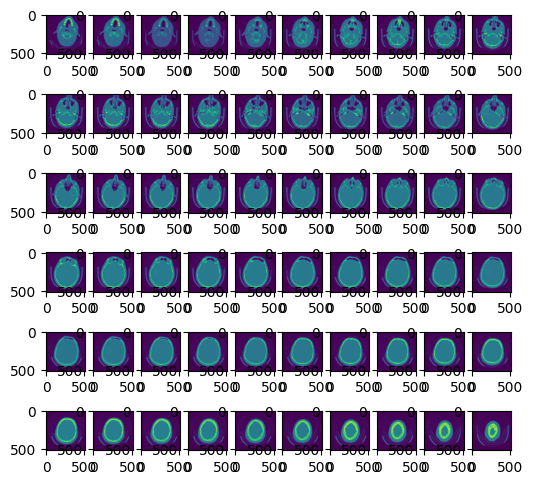

In [6]:
fig, axs = plt.subplots(6, 10, figsize = (6, 6))
cur_im = 0
for i in range(6):
    for j in range(10):
        axs[i][j].imshow(images[cur_im])
        cur_im += 1

In [7]:
def make_mesh(image, threshold=-300, step_size=1):
    p = image.transpose(2,1,0)
    verts, faces, norm, val = measure.marching_cubes(p, threshold, step_size=step_size, allow_degenerate=True) 
    return verts, faces

In [8]:
def plotly_3d(verts, faces):
    x,y,z = zip(*verts) 
    
    # Make the colormap single color since the axes are positional not intensity. 
#    colormap=['rgb(255,105,180)','rgb(255,255,51)','rgb(0,191,255)']
    colormap=['rgb(236, 236, 212)','rgb(236, 236, 212)']
    
    fig = FF.create_trisurf(x=x,
                        y=y, 
                        z=z, 
                        plot_edges=False,
                        colormap=colormap,
                        simplices=faces,
                        backgroundcolor='rgb(64, 64, 64)',
                        title="Interactive Visualization")
    iplot(fig)

In [9]:
def plt_3d(verts, faces):
    x,y,z = zip(*verts) 
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], linewidths=0.05, alpha=1)
    mesh.set_facecolor('gray')
    ax.add_collection3d(mesh)

    ax.set_xlim(0, max(x))
    ax.set_ylim(0, max(y))
    ax.set_zlim(0, max(z))
    plt.show()

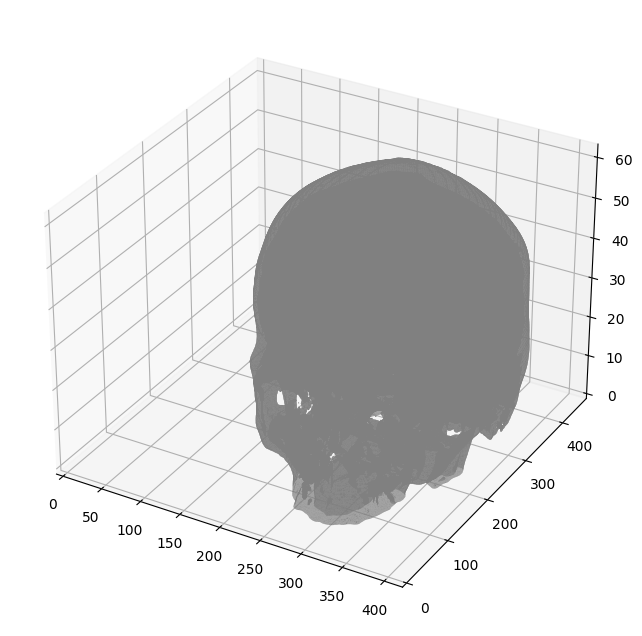

In [10]:
v, f = make_mesh(images, 350)
plt_3d(v, f)